<a href="https://colab.research.google.com/github/Clevincio/project1/blob/main/Drug_reaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#   **Part A Loading data and preliminary cleaning**
##    **Adverse drug reaction predicting system**

I will be creating a machine learning algorithin using data downloaded from FAERS (FDA Adverse Event Reporting System)
I will be doing preliminary cleaning and merging the data using primary key to make one to one relationship from demo.txt,drug.txt,out.txt. to come up with one dataframe

In [ ]:
import pandas as pd

#loading csv files
demo_df = pd.read_csv('demo_data.csv')
drug_df = pd.read_csv('drug_data.csv')
outcomes_df = pd.read_csv("outcomes_data.csv")
reaction_df = pd.read_csv("reactions_data.csv")

#merging the dataframes
merged_df = pd.merge(demo_df,drug_df, on="primaryid", how="inner")
merged_df = pd.merge(merged_df,outcomes_df, on="primaryid", how="inner")
reaction_df = reaction_df.drop_duplicates()

print(merged_df.columns)



Index(['primaryid', 'caseid_x', 'caseversion', 'i_f_code', 'rept_cod',
       'mfr_num', 'mfr_sndr', 'age', 'age_cod', 'sex', 'wt', 'wt_cod',
       'caseid_y', 'role_cod', 'drugname', 'prod_ai', 'route', 'nda_num',
       'dose_amt', 'dose_unit', 'caseid', 'outc_cod'],
      dtype='object')


In [ ]:
#preliminary cleaning
merged_df = merged_df.loc[merged_df["dose_unit"] != "NaN"]
merged_df.drop(['caseid_x','rept_cod','mfr_num','mfr_sndr','caseid_y', 'role_cod', 'caseid',], inplace=True,axis=1)
merged_df.drop(['caseversion'],axis=1,inplace=True)
merged_df.dropna(axis=0, how = 'any', inplace=True)
merged_df.drop_duplicates(subset=['primaryid'], keep="first",inplace=True)
merged_df.reindex(columns=['nda_num','drugname','dose_amt','dose_unit','age','age_cod','wt', 'wt_cod','sex','outc_cod','route'])


,nda_num,drugname,dose_amt,dose_unit,age,age_cod,wt,wt_cod,sex,outc_cod,route
44,103976.0,XOLAIR,225.0,MG,57.0,YR,53.00,KG,M,HO,Subcutaneous
78,103976.0,XOLAIR,300.0,MG,39.0,YR,112.00,KG,F,OT,Subcutaneous
107,125276.0,ACTEMRA,350.0,MG,52.0,YR,89.50,KG,M,HO,Intravenous (not otherwise specified)
155,103976.0,XOLAIR,225.0,MG,57.0,YR,74.00,KG,M,OT,Subcutaneous
163,22000.0,MESALAMINE,3.6,GM,44.0,YR,61.22,KG,F,OT,Oral
...,...,...,...,...,...,...,...,...,...,...,...
1995914,103976.0,XOLAIR,375.0,MG,65.0,YR,93.00,KG,M,OT,Subcutaneous
1996072,103705.0,RITUXAN,1000.0,MG,31.0,YR,95.00,KG,F,HO,Intravenous (not otherwise specified)
1996144,103705.0,RITUXAN,1000.0,MG,18.0,YR,58.10,KG,F,OT,Intravenous drip
1996196,125276.0,ACTEMRA,560.0,MG,46.0,YR,77.00,KG,F,OT,Intravenous (not otherwise specified)


In [ ]:
merged_df.dropna(axis=0, how = 'any', inplace=True)

In [ ]:
#creating new row for out comes with o being nan fatal and  being fatal
serious_codes = ['DE', 'LT', 'HO', 'DS', 'CA', 'RI']
merged_df['outc_cod_Serious'] = merged_df['outc_cod'].isin(serious_codes).astype(int)


In [ ]:
#removing data whose doe unit is not mg or years not yrs
merged_data = merged_df[(merged_df["dose_unit"] == "MG") & (merged_df["age_cod"] == "YR")]
merged_data = merged_data[merged_data["wt_cod"] == "KG"]

In [ ]:
merged_data.head()

,primaryid,i_f_code,age,age_cod,sex,wt,wt_cod,drugname,prod_ai,route,nda_num,dose_amt,dose_unit,outc_cod,outc_cod_Serious
44,1005762118,F,57.0,YR,M,53.0,KG,XOLAIR,OMALIZUMAB,Subcutaneous,103976.0,225.0,MG,HO,1
78,1013616272,F,39.0,YR,F,112.0,KG,XOLAIR,OMALIZUMAB,Subcutaneous,103976.0,300.0,MG,OT,0
107,1014222252,F,52.0,YR,M,89.5,KG,ACTEMRA,TOCILIZUMAB,Intravenous (not otherwise specified),125276.0,350.0,MG,HO,1
155,1014280316,F,57.0,YR,M,74.0,KG,XOLAIR,OMALIZUMAB,Subcutaneous,103976.0,225.0,MG,OT,0
175,1016133060,F,66.0,YR,F,62.0,KG,ACTEMRA,TOCILIZUMAB,Intravenous (not otherwise specified),125276.0,528.0,MG,OT,0


In [ ]:
#creating predicting dataframe
predicting_data = merged_data[["age","sex","wt","route","outc_cod_Serious","nda_num","dose_amt"]]

In [ ]:
print(predicting_data.columns)

Index(['age', 'sex', 'wt', 'route', 'outc_cod_Serious', 'nda_num', 'dose_amt'], dtype='object')


In [ ]:
#making route data to be uniform
# Define valid FDA routes and their standardized names
route_mapping = {
    'intravenous': 'iv',
    'intravenous (not otherwise specified)': 'iv',
    'intravenous bolus': 'iv',
    'intravenous infusion': 'iv',
    'subcutaneous': 'subcutaneous',
    'oral': 'oral',
    'topical': 'topical',
    'inhalation': 'inhalation',
    'intramuscular': 'im',
    'intrathecal': 'intrathecal',
    'rectal': 'rectal',
    'transdermal': 'transdermal'
}

# Convert route column to lowercase and map to standard names
predicting_data['route'] = predicting_data['route'].str.lower().map(route_mapping)

# Drop rows where route is NaN (i.e., not in FDA-defined routes)
predicting_data = predicting_data.dropna(subset=['route'])

# Convert all column names to lowercase
predicting_data.columns = predicting_data.columns.str.lower()

print(predicting_data.head())

      age sex     wt         route  outc_cod_serious   nda_num  dose_amt
44   57.0   M   53.0  subcutaneous                 1  103976.0     225.0
78   39.0   F  112.0  subcutaneous                 0  103976.0     300.0
107  52.0   M   89.5            iv                 1  125276.0     350.0
155  57.0   M   74.0  subcutaneous                 0  103976.0     225.0
175  66.0   F   62.0            iv                 0  125276.0     528.0


<ipython-input-70-ee4567a03721>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicting_data['route'] = predicting_data['route'].str.lower().map(route_mapping)


In [ ]:
predicting_data

,age,sex,wt,route,outc_cod_serious,nda_num,dose_amt
44,57.0,M,53.0,subcutaneous,1,103976.0,225.0
78,39.0,F,112.0,subcutaneous,0,103976.0,300.0
107,52.0,M,89.5,iv,1,125276.0,350.0
155,57.0,M,74.0,subcutaneous,0,103976.0,225.0
175,66.0,F,62.0,iv,0,125276.0,528.0
...,...,...,...,...,...,...,...
1995768,39.0,F,75.0,iv,1,125276.0,640.0
1995914,65.0,M,93.0,subcutaneous,0,103976.0,375.0
1996072,31.0,F,95.0,iv,1,103705.0,1000.0
1996196,46.0,F,77.0,iv,0,125276.0,560.0


In [ ]:
#resetting the index
predicting_data = predicting_data.reset_index(drop=True)
predicting_data

,age,sex,wt,route,outc_cod_serious,nda_num,dose_amt
0,57.0,M,53.0,subcutaneous,1,103976.0,225.0
1,39.0,F,112.0,subcutaneous,0,103976.0,300.0
2,52.0,M,89.5,iv,1,125276.0,350.0
3,57.0,M,74.0,subcutaneous,0,103976.0,225.0
4,66.0,F,62.0,iv,0,125276.0,528.0
...,...,...,...,...,...,...,...
15648,39.0,F,75.0,iv,1,125276.0,640.0
15649,65.0,M,93.0,subcutaneous,0,103976.0,375.0
15650,31.0,F,95.0,iv,1,103705.0,1000.0
15651,46.0,F,77.0,iv,0,125276.0,560.0


#            **Part B converting categorical data to numerical**

---
creating the model


1.   Converting categorical data into numerical






In [ ]:
#converting categorical data into numerical
predicting_data = pd.get_dummies(predicting_data, columns=['sex', 'route'])


In [ ]:
predicting_data

,age,wt,outc_cod_serious,nda_num,dose_amt,sex_F,sex_M,route_im,route_intrathecal,route_iv,route_oral,route_rectal,route_subcutaneous,route_topical,route_transdermal
0,57.0,53.0,1,103976.0,225.0,False,True,False,False,False,False,False,True,False,False
1,39.0,112.0,0,103976.0,300.0,True,False,False,False,False,False,False,True,False,False
2,52.0,89.5,1,125276.0,350.0,False,True,False,False,True,False,False,False,False,False
3,57.0,74.0,0,103976.0,225.0,False,True,False,False,False,False,False,True,False,False
4,66.0,62.0,0,125276.0,528.0,True,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15648,39.0,75.0,1,125276.0,640.0,True,False,False,False,True,False,False,False,False,False
15649,65.0,93.0,0,103976.0,375.0,False,True,False,False,False,False,False,True,False,False
15650,31.0,95.0,1,103705.0,1000.0,True,False,False,False,True,False,False,False,False,False
15651,46.0,77.0,0,125276.0,560.0,True,False,False,False,True,False,False,False,False,False


In [5]:
# Convert all columns to numeric (int or float)
predicting_data = predicting_data.apply(pd.to_numeric, errors='coerce')
#changing the booleans
columns_to_convert = ['sex_F', 'sex_M', 'route_im','route_intrathecal', 'route_iv',
                      'route_oral', 'route_rectal', 'route_subcutaneous','route_transdermal', 'route_topical']

predicting_data[columns_to_convert] = predicting_data[columns_to_convert].astype(int)
predicting_data['nda_num'].astype(float)

,nda_num
0,103976.0
1,103976.0
2,125276.0
3,103976.0
4,125276.0
...,...
15648,125276.0
15649,103976.0
15650,103705.0
15651,125276.0


In [7]:
predicting_data.to_csv("predicting_df.csv", index=False)


**# Part c graphical analysis**
**ill perform some graphical analysis to see if the data i selected for analysis is enought to come up with a model**

In [19]:
predicting_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15653 entries, 0 to 15652
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 15653 non-null  float64
 1   wt                  15653 non-null  float64
 2   outc_cod_serious    15653 non-null  int64  
 3   nda_num             15653 non-null  float64
 4   dose_amt            15653 non-null  float64
 5   sex_F               15653 non-null  int64  
 6   sex_M               15653 non-null  int64  
 7   route_im            15653 non-null  int64  
 8   route_intrathecal   15653 non-null  int64  
 9   route_iv            15653 non-null  int64  
 10  route_oral          15653 non-null  int64  
 11  route_rectal        15653 non-null  int64  
 12  route_subcutaneous  15653 non-null  int64  
 13  route_topical       15653 non-null  int64  
 14  route_transdermal   15653 non-null  int64  
dtypes: float64(4), int64(11)
memory usage: 1.8 MB


In [20]:
#statistical information for the entire table
predicting_data.drop(columns=["nda_num"]).describe().T


,count,mean,std,min,25%,50%,75%,max
age,15653.0,59.387657,19.614102,0.00,49.0,64.0,74.0,101.0
wt,15653.0,73.339629,23.580455,0.00,59.0,70.0,85.0,555.0
outc_cod_serious,15653.0,0.546924,0.497809,0.00,0.0,1.0,1.0,1.0
dose_amt,15653.0,257.813730,733.332718,0.03,14.0,75.0,300.0,56000.0
sex_F,15653.0,0.567176,0.495483,0.00,0.0,1.0,1.0,1.0
sex_M,15653.0,0.432824,0.495483,0.00,0.0,0.0,1.0,1.0
route_im,15653.0,0.011755,0.107785,0.00,0.0,0.0,0.0,1.0
route_intrathecal,15653.0,0.002044,0.045170,0.00,0.0,0.0,0.0,1.0
route_iv,15653.0,0.202198,0.401652,0.00,0.0,0.0,0.0,1.0
route_oral,15653.0,0.610618,0.487626,0.00,0.0,1.0,1.0,1.0


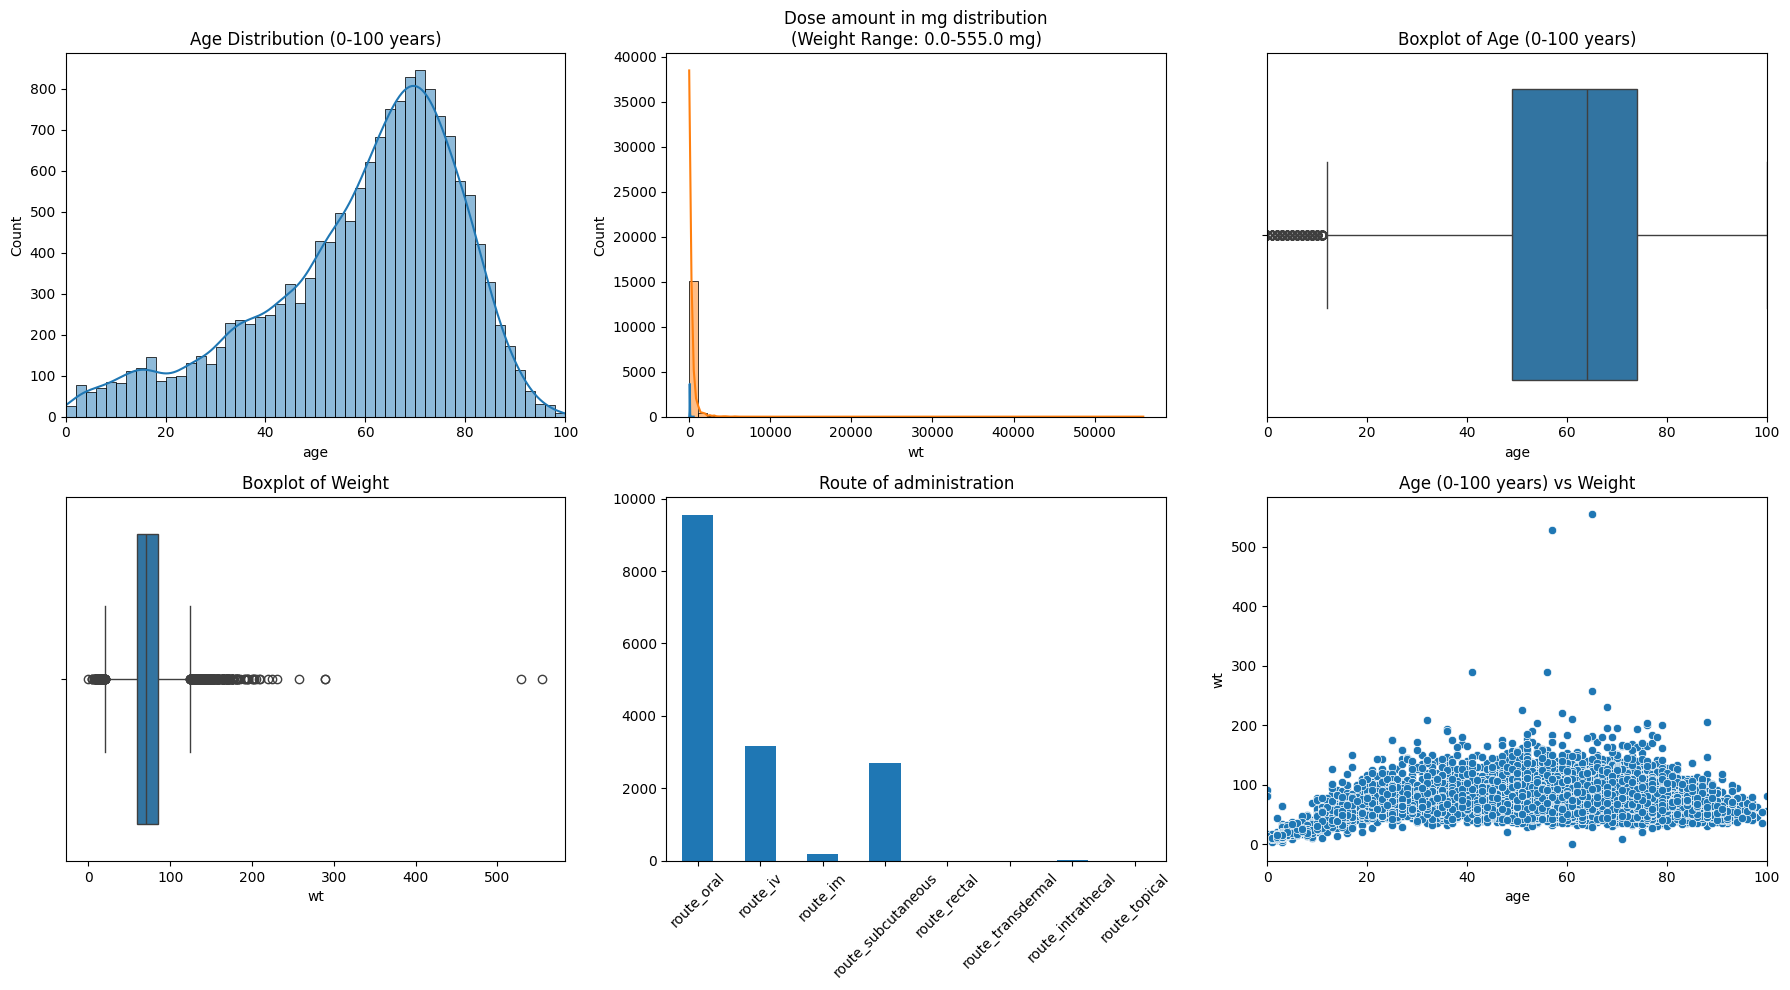

In [22]:
#graphs
import seaborn as sns
import matplotlib.pyplot as plt

# Sample Data (replace with your actual dataset)
df = predicting_data


# Filter age between 0 and 100 years
df_filtered = df[(df['age'] >= 0) & (df['age'] <= 100)]

# Define figure and axes
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Histogram for Age
sns.histplot(df_filtered['age'], bins=50, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Age Distribution (0-100 years)")
axes[0, 0].set_xlim(0, 100)

# Histogram for Weight
sns.histplot(df['wt'], bins=50, kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Weight Distribution")

# Get min and max weight
min_wt = df["wt"].min()
max_wt = df["wt"].max()

# Histogram for dose amount in mg (only for selected weight range)
sns.histplot(df["dose_amt"], bins=50, kde=True, ax=axes[0, 1])
axes[0, 1].set_title(f"Dose amount in mg distribution\n(Weight Range: {min_wt}-{max_wt} mg)")



# Boxplot for Age
sns.boxplot(x=df_filtered['age'], ax=axes[0, 2])
axes[0, 2].set_title("Boxplot of Age (0-100 years)")
axes[0, 2].set_xlim(0, 100)

# Boxplot for Weight
sns.boxplot(x=df['wt'], ax=axes[1, 0])
axes[1, 0].set_title("Boxplot of Weight")

# Bar plot for route of administration
categorical_vars = ['route_oral', 'route_iv',
                    'route_im', 'route_subcutaneous', 'route_rectal','route_transdermal','route_intrathecal', 'route_topical']

df[categorical_vars].sum().plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title("Route of administration")
axes[1, 1].tick_params(axis='x', rotation=45)

# Scatter plot for Age vs Weight
sns.scatterplot(x=df_filtered['age'], y=df['wt'], ax=axes[1, 2])
axes[1, 2].set_title("Age (0-100 years) vs Weight")
axes[1, 2].set_xlim(0, 100)

# Adjust layout
plt.tight_layout()
plt.show()

# **Part C-Creating & saving model,**

In [58]:
# Removing nda number
predicting_data = predicting_data.drop(columns=["nda_num"])

In [59]:
predicting_data.columns

Index(['age', 'wt', 'outc_cod_serious', 'dose_amt', 'sex_F', 'sex_M',
       'route_im', 'route_intrathecal', 'route_iv', 'route_oral',
       'route_rectal', 'route_subcutaneous', 'route_topical',
       'route_transdermal'],
      dtype='object')

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [69]:
# Define model and hyperparameters
rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [150,300,600],
    'max_depth': [20,30,40],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Perform Grid Search
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='accuracy', verbose=0)
grid_search.fit(X_train, y_train)

# Get best model and accuracy
best_rf = grid_search.best_estimator_
print("Best Params:", grid_search.best_params_)
print("Best Accuracy:", best_rf.score(X_test, y_test))


Best Params: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best Accuracy: 0.6020440753752795


In [75]:
# Define target variable
y = predicting_data["outc_cod_serious"]
X = predicting_data.drop(columns=["outc_cod_serious"])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=2,
    random_state=42
)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Accuracy
print("Model Accuracy:", accuracy_score(y_test, y_pred))


Model Accuracy: 0.6020440753752795


## saving the model


In [77]:
import pickle
with open("predicting_model", "wb") as f:
  pickle.dump(model, f)

In [78]:
#using the model
with open("predicting_model", "rb") as f:
  mp = pickle.load(f)

In [79]:
predicting_data.columns

Index(['age', 'wt', 'outc_cod_serious', 'dose_amt', 'sex_F', 'sex_M',
       'route_im', 'route_intrathecal', 'route_iv', 'route_oral',
       'route_rectal', 'route_subcutaneous', 'route_topical',
       'route_transdermal'],
      dtype='object')

In [84]:
routes = ["im", "intrathecal", "iv", "oral", "rectal", "subcutaneous", "topical", "transdermal"]
age = float(input("Enter Age: "))
wt = float(input("Enter Weight: "))
dose = float(input("Enter Dose Amount: "))
route = input(f"Enter Route {routes}: ").strip().lower()

user_data = {
    "age": age, "wt": wt,"dose_amt": dose, "sex_F": 0, "sex_M": 1
}
user_data.update({f"route_{r}": int(route == r) for r in routes})  # One-hot encode route

# Predict
prediction = mp.predict(pd.DataFrame([user_data]))
print("Prediction:", prediction[0])


Enter Age: 344
Enter Route ['im', 'intrathecal', 'iv', 'oral', 'rectal', 'subcutaneous', 'topical', 'transdermal']: oral
Prediction: 0


## **`testing the model`**

In [89]:
routes = ["im", "intrathecal", "iv", "oral", "rectal", "subcutaneous", "topical", "transdermal"]
# Validate input
age = float(input("Enter Age in yrs: "))
while age < 0 or age > 100:
    age = float(input("Invalid age. Enter Age in yrs: "))
wt = float(input("Enter Weight in KG: "))
while wt < 0 or wt > 500:
    wt = float(input("Invalid weight. Enter Weight in KG: "))
dose = float(input("Enter Dose Amount in MG: "))
while dose < 0 or dose > 1000:
    dose = float(input("Invalid dose. Enter Dose Amount in MG: "))
route = input(f"Enter Route {routes}: ").strip().lower()
while route not in routes:
    route = input(f"Invalid route. Enter Route {routes}: ").strip().lower()
sex = input("Enter Sex (F/M): ").strip().lower()
while sex not in ["f", "m"]:
    sex = input("Invalid input. Enter Sex (F/M): ").strip().lower()

user_data = {
    "age": age,
    "wt": wt,
    "dose_amt": dose,
    "sex_F": 1 if sex == "f" else 0,
    "sex_M": 1 if sex == "m" else 0
}

# One-hot encode route
user_data.update({f"route_{r}": int(route == r) for r in routes})

# Predict
prediction = mp.predict(pd.DataFrame([user_data]))
if prediction[0] == 1:
    print("Prediction: FATAL")
else:
    print("Prediction: Non-Fatal")


Enter Age in yrs: 455
Invalid age. Enter Age in yrs: 34
Enter Weight in KG: 76
Enter Dose Amount in MG: 0.005
Enter Route ['im', 'intrathecal', 'iv', 'oral', 'rectal', 'subcutaneous', 'topical', 'transdermal']: iv
Enter Sex (F/M): m
Prediction: Non-Fatal


In [91]:
from google.colab import files
files.download("predicting_model")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>